Random Clifford circuit

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Pauli, Clifford, SparsePauliOp, Operator, Statevector
from qiskit import QuantumCircuit
import time
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from collections import Counter, defaultdict

At every odd (even) time step a set of SWAP gates is applied on the odd (even) bonds, with probability 0 ≤ p ≤ 1 on each bond. Then, a set of CNOT gates is applied on a fraction 0 ≤ r ≤ 1/2 of all the bonds. The bonds are chosen such that only configurations where no two bonds share a site are allowed and each such configuration is equally probable. The role of each qubit (control or target) is chosen randomly and independently for each pair of sites.

In [108]:

def create_circuit_layers(n_qubits, time, p, r):
    """
    Generate a list of QuantumCircuits, one per time step, implementing
    the random SWAP + CNOT dynamics as in Keselman et al.

    Returns:
        layers: list of QuantumCircuit of depth 1 (one SWAP+CNOT layer each)
    """
    assert 0 <= r <= 0.5, "r must be in [0, 0.5]"
    assert n_qubits >= 2, "At least 2 qubits are needed"

    layers = []
    for t_step in range(time):
        qc = QuantumCircuit(n_qubits)
        parity = t_step % 2

        # SWAP layer
        for i in range(parity, n_qubits - 1, 2):
            if np.random.rand() < p:
                qc.swap(i, i + 1)

        # CNOT layer
        all_bonds = [(i, i + 1) for i in range(0, n_qubits - 1, 2)] + \
                    [(i, i + 1) for i in range(1, n_qubits - 1, 2)]
        np.random.shuffle(all_bonds)

        selected = []
        used = set()
        max_cnots = int(r * (n_qubits - 1))
        for (a, b) in all_bonds:
            if a not in used and b not in used:
                if len(selected) >= max_cnots:
                    break
                selected.append((a, b))
                used.update([a, b])

        for a, b in selected:
            if np.random.rand() < 0.5:
                qc.cx(a, b)
            else:
                qc.cx(b, a)

        layers.append(qc)
    return layers

In [109]:
def U_at_time(layers, time):
    if not (0 <= time < len(layers)):
        raise IndexError("time fuera de rango")
    U = Operator(layers[0])
    for idx in range(1, time+1):
        U = Operator(layers[idx]) @ U

    return U

def Clifford_at_time(layers, time, n_qubits):
    if not (0 <= time < len(layers)):
        raise IndexError("t fuera de rango")
    
    qc = QuantumCircuit(n_qubits)
    
    for layer in layers[:time+1]:
        qc.compose(layer, inplace=True)   

    return Clifford(qc)

def satate_at_time(layers, time, n_qubits):
    if not (0 <= time < len(layers)):
        raise IndexError("t fuera de rango")
    
    qc = QuantumCircuit(n_qubits)
    
    for layer in layers[:time+1]:
        qc.compose(layer, inplace=True)    
    
    psi = Statevector.from_instruction(qc)
    return psi

def heisenberg_evolve_pauli(n_qubits, layers, init_site, time):
    """
    Evolve the operator W_i(0) = Z_i / sqrt(2) in Heisenberg picture
    through each layer, returning a list of SparsePauliOp objects.
    """
    # initial Pauli string: Z on init_site, I elsewhere
    z_pauli = ['I'] * n_qubits
    z_pauli[init_site] = 'Z'
    W = SparsePauliOp(Pauli(''.join(reversed(z_pauli))), 1/np.sqrt(2))
    
    U = U_at_time(layers, time)
    
    W_mat = U.adjoint().data @ W.to_matrix() @ U.data
    W = SparsePauliOp.from_operator(Operator(W_mat))
    
    return W


def compute_Cij(W: SparsePauliOp, j: int, n_qubits: int, state):
    """
    Compute C_{i,j}(t) 
    """
    # Build V_j
    x_pauli = ['I'] * n_qubits
    x_pauli[j] = 'X'
    V = SparsePauliOp(Pauli(''.join(reversed(x_pauli))), 1/np.sqrt(2))

    # comm = Pauli.commutes(W, V)
    # Convert to matrices
    Wm = W.to_matrix()
    Vm = V.to_matrix()

    comm = Wm @ Vm - Vm @ Wm
    comm2 = comm @ comm
    
    return state.expectation_value(comm2) 


def compute_iOTOC(n_qubits, time, layers, init_site):
    """
    Main function: builds layers, evolves W_i, and computes f(t) for all t.
    Returns:
        times: list of t=0..time
        f_vals: list of iOTOC values
    """
    
    f_vals = []
    for t in range(time):
        state = satate_at_time(layers, t, n_qubits)
        Wt = heisenberg_evolve_pauli(n_qubits, layers, init_site, t)
        C_vals = [-compute_Cij(Wt, j, n_qubits, state) for j in range(n_qubits)]
        f_vals.append(sum(C_vals))
    return list(range(len(f_vals))), np.real(f_vals), layers


In [110]:
def density_paulis(pauli_str):
    """
    Compute the density of Z Pauli operators in a given string.
    """
    pauli_str = pauli_str.to_label()   
    length = len(pauli_str)
    center = length // 2
    z_positions = [i - center for i, op in enumerate(pauli_str) if op == 'Z']
    
    return z_positions, len(z_positions)

def counts_paulis(pauli_str):
    """
    Compute the density of Z Pauli operators in a given string.
    """
    count = 0
    pauli_str = pauli_str.to_label()
    for op in pauli_str:
        if op == 'Z':
            count += 1
    return count

def compute_iOTOC_counts(n_qubits, time, layers, init_site):

    """
    Compute the iOTOC for a given time, p, and r, counting the number of Z paulis operators.
    """
    #layers = create_circuit_layers(n_qubits, time, p, r)
    # Build W_i(0)
    Z_pauli_initial = ['I'] * n_qubits
    Z_pauli_initial[init_site] = 'Z'
    W = Pauli("".join(Z_pauli_initial))
    
    counts = []
    positions = []
    
    for t in range(time):
        U = Clifford_at_time(layers, t, n_qubits)
        Wt = W.evolve(U)  # Evolve the Pauli operator with U
        pos, count = density_paulis(Wt)
        counts.append(count)
        positions.append(pos)
        
    return list(range(len(counts))), counts, positions

def compute_butterfly_velocity(positinos, n_qubits):
    left_values = []
    right_values = []

    for i in range(len(positinos)):
        left_values.append(positinos[i][0])
        right_values.append(positinos[i][-1])
            
        if positinos[i][0] == -n_qubits // 2 or positinos[i][-1] == n_qubits // 2:
            break

    left_fit = np.polyfit(range(len(left_values)), left_values, 1)
    right_fit = np.polyfit(range(len(right_values)), right_values, 1)
    left_slope = -left_fit[0]
    right_slope = right_fit[0]


    return 1/(np.mean([left_slope, right_slope]))
    

Execution time for compute_iOTOC: 0.9033 seconds


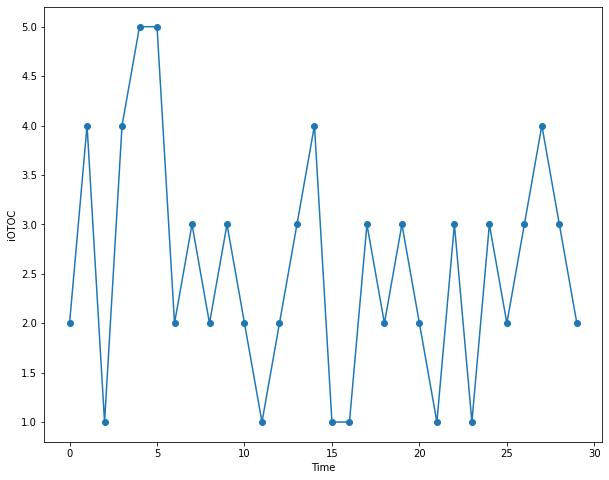

Execution time for compute_iOTOC_counts: 0.0778 seconds


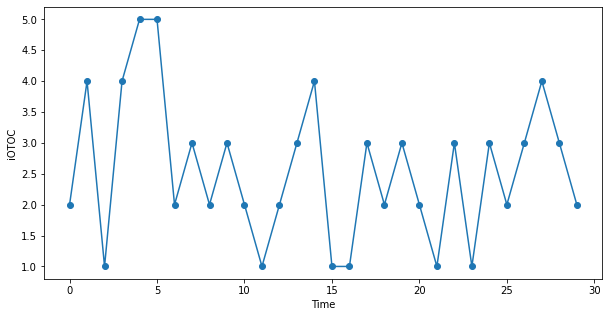

In [111]:
import time

L = 5
T = 30  
p = 0.9
r = 0.5

layers = create_circuit_layers(L,T, p, r)

start_time1 = time.time()
iOTOC_times1, iOTOC_vals1, layers = compute_iOTOC(L, T, layers, init_site=L//2)
end_time1 = time.time()
print(f"Execution time for compute_iOTOC: {end_time1 - start_time1:.4f} seconds")    
    
plt.figure(figsize=(10, 8))
plt.plot(iOTOC_times1, iOTOC_vals1, marker='o')
plt.xlabel('Time')
plt.ylabel('iOTOC')
plt.show()

start_time2 = time.time()
iOTOC_times2, iOTOC_vals2, density = compute_iOTOC_counts(L, T, layers, init_site=L//2)
end_time2 = time.time()
print(f"Execution time for compute_iOTOC_counts: {end_time2 - start_time2:.4f} seconds")

plt.figure(figsize=(10, 5))
plt.plot(iOTOC_times2, iOTOC_vals2, marker='o')
plt.xlabel('Time')
plt.ylabel('iOTOC')
plt.show()



Execution time for compute_iOTOC_counts: 102.9267 seconds
Butterfly velocity:  2.2488955885232405


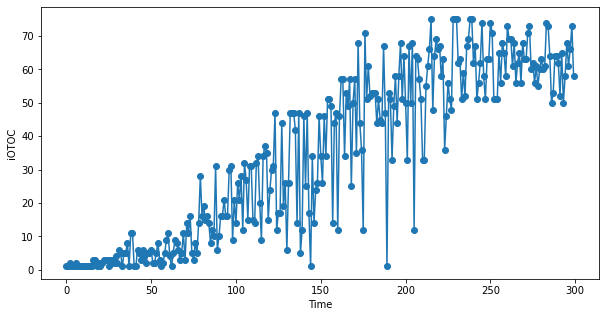

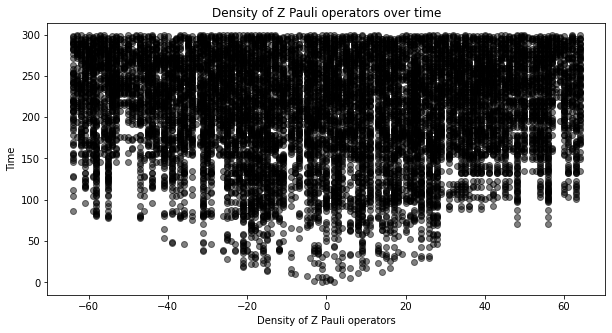

In [135]:
L = 129
T = 300
p = 0.9
r = 0.05

layers = create_circuit_layers(L,T, p, r)

start_time = time.time()
iOTOC_times, iOTOC_vals, density = compute_iOTOC_counts(L, T, layers, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute_iOTOC_counts: {end_time - start_time:.4f} seconds")

Butterfly_velocity = compute_butterfly_velocity(density, L)
print("Butterfly velocity: ", Butterfly_velocity)

plt.figure(figsize=(10, 5))
plt.plot(iOTOC_times, iOTOC_vals, marker='o')
plt.xlabel('Time')
plt.ylabel('iOTOC')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(len(density)):
    plt.scatter(density[i], [i]*len(density[i]), marker='o', color='black', alpha=0.5)
 
plt.xlabel('Density of Z Pauli operators')
plt.ylabel('Time')
plt.title('Density of Z Pauli operators over time')
plt.show()


In [ ]:
def single_OTOC(n_qubits, t, layers, W):
    U = Clifford_at_time(layers, t, n_qubits)
    Wt = W.evolve(U)
    z_positions, count = density_paulis(Wt)
    return z_positions, count

def run_OTOC_instance(n_qubits, time, layers, W):
    return [single_OTOC(n_qubits, t, layers, W) for t in range(time)]

def compute_iOTOC_counts_savedata(iteration, n_qubits, time, p, r, init_site):
    filename = f"iOTOC_n{n_qubits}_t{time}_p{p}_r{r}.dat"
    filepath = os.path.join("numerical_data", filename)

    Z_pauli_initial = ['I'] * n_qubits
    Z_pauli_initial[init_site] = 'Z'
    W = Pauli("".join(Z_pauli_initial))

    layers_list = Parallel(n_jobs=-1)(
        delayed(create_circuit_layers)(n_qubits, time, p, r) for _ in range(iteration)
    )
    
    print("Layers created")
    
    all_results = Parallel(n_jobs=-1)(
        delayed(run_OTOC_instance)(n_qubits, time, layers_list[i], W) for i in tqdm(range(iteration))
    )

    results_by_time = list(zip(*all_results))

    with open(filepath, "w") as f:
        f.write("t\tiOTOC\tDensities\n")
        for t, results_at_t in enumerate(results_by_time):
            counts = [count for _, count in results_at_t]
            iOTOC = np.mean(counts)

            all_positions = [pos for pos_list, _ in results_at_t for pos in pos_list]
            position_counts = Counter(all_positions)
            densities = {pos: position_counts[pos] / iteration for pos in sorted(position_counts)}
            densities_str = " ".join(f"{pos}:{densities[pos]:.4f}" for pos in densities)

            f.write(f"{t}\t{iOTOC:.6f}\t{densities_str}\n")
     
     

In [167]:
def compute_butterfly_velocity_from_file(filepath, n_qubits, epsilon=1e-3):
    left_values = []
    right_values = []

    with open(filepath, "r") as f:
        lines = f.readlines()[1:]  # saltar encabezado

    for t, line in enumerate(lines):
        parts = line.strip().split("\t")
        if len(parts) < 3:
            continue  # si no hay densidades, salta

        density_str = parts[2]
        densities = {}
        for item in density_str.split():
            pos, val = item.split(":")
            densities[int(pos)] = float(val)

        # Filtrar por epsilon
        active_positions = [pos for pos, dens in densities.items() if dens >= epsilon]
        if not active_positions:
            continue

        left = min(active_positions)
        right = max(active_positions)

        left_values.append(left)
        right_values.append(right)

        # Condición de paro opcional si llega a los bordes del sistema
        if left <= -n_qubits // 2 or right >= n_qubits // 2:
            break

    if len(left_values) < 2 or len(right_values) < 2:
        raise ValueError("No se encontraron suficientes datos activos para estimar la velocidad.")

    # Ajuste lineal
    t_values = range(len(left_values))
    left_fit = np.polyfit(t_values, left_values, 1)
    right_fit = np.polyfit(t_values, right_values, 1)

    left_slope = -left_fit[0]
    right_slope = right_fit[0]

    return np.mean([left_slope, right_slope])
      
def plot(filepath):
    iOTOC_times = []
    iOTOC_vals = []

    # Mapa: lista de diccionarios tiempo -> {posicion: densidad}
    density_data = []
    # Leer archivo
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith("t"):
                continue  
            parts = line.strip().split()
            if len(parts) >= 2:
                t = int(parts[0])
                val = float(parts[1])
                iOTOC_times.append(t)
                iOTOC_vals.append(val)

                # Procesar densidades
                densities = {}
                for pair in parts[2:]:
                    if ':' in pair:
                        pos, dens = pair.split(':')
                        densities[int(pos)] = float(dens)
                density_data.append(densities)

    # Encontrar todas las posiciones usadas
    all_positions = sorted({pos for dens in density_data for pos in dens.keys()})
    position_indices = {pos: i for i, pos in enumerate(all_positions)}

    # Construir matriz para mapa de calor (tiempo x posicion)
    heatmap = np.zeros((len(density_data), len(all_positions)))

    for t_idx, dens_dict in enumerate(density_data):
        for pos, dens in dens_dict.items():
            x_idx = position_indices[pos]
            heatmap[t_idx, x_idx] = dens

    # --- Gráfica iOTOC vs tiempo ---
    Butterfly_velocity = compute_butterfly_velocity_from_file(filepath, L)
    print("Butterfly velocity: ", Butterfly_velocity)
    iOTOC_vals_norm = [iOTOC / (2 * Butterfly_velocity * (i + 1)) for i, iOTOC in enumerate(iOTOC_vals)]
    plt.figure(figsize=(10, 5))
    plt.plot(iOTOC_times, iOTOC_vals, marker='o')
    plt.xlabel('Time')
    plt.ylabel('iOTOC')
    plt.title('iOTOC vs Time')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Mapa de calor ---
    plt.figure(figsize=(12, 6))
    plt.imshow(heatmap, aspect='auto', origin='lower', cmap='viridis',
            extent=[min(all_positions), max(all_positions), 0, len(iOTOC_times)])
    plt.colorbar(label='Density')
    plt.xlabel('Position')
    plt.ylabel('Time')
    plt.title('Position Density Heatmap over Time')
    plt.tight_layout()
    plt.ylim(0, 200)
    plt.show()

# iOTOC_vals_norm = [iOTOC / (2 * Butterfly_velocity * (i + 1)) for i, iOTOC in enumerate(iOTOC_vals)]

In [ ]:
L = 129
T = 500
p = 0.9
r = 0.05

iteration = 1000

start_time = time.time()     
compute_iOTOC_counts_savedata(iteration, L, T, p, r, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute all iOTOC_counts: {end_time - start_time:.4f} seconds")

filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda

Layers created


100%|██████████| 1000/1000 [6:42:18<00:00, 24.14s/it] 


Execution time for compute all iOTOC_counts: 26519.6464 seconds


Butterfly velocity:  0.9717719780219779


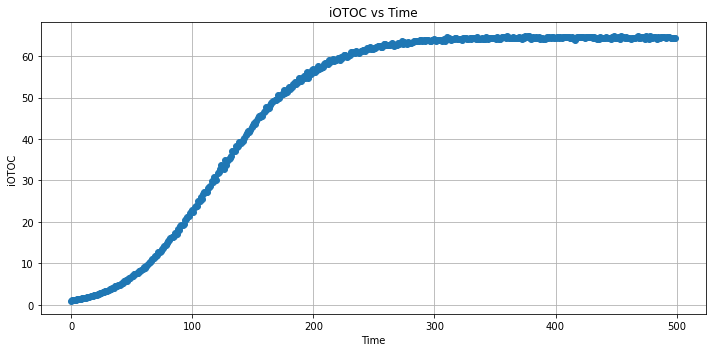

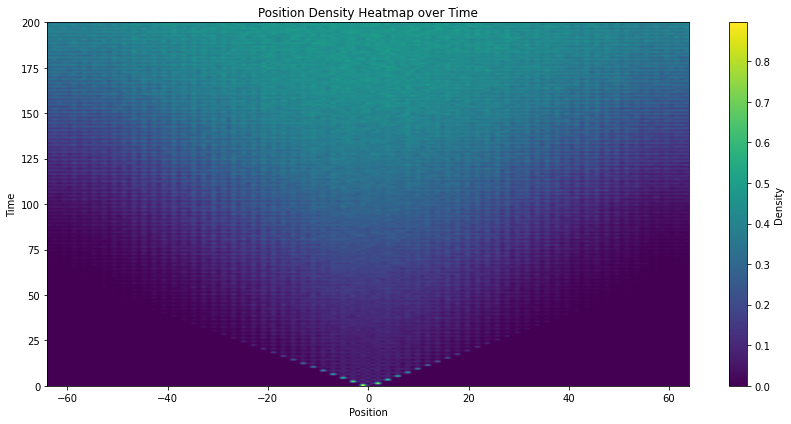

In [168]:
L = 129
T = 500
p = 0.9
r = 0.05
filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda
plot(filepath)

In [139]:
L = 129
T = 500
p = 1
r = 0.05

iteration = 1000

start_time = time.time()     
compute_iOTOC_counts_savedata(iteration, L, T, p, r, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute all iOTOC_counts: {end_time - start_time:.4f} seconds")

filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda

Layers created


100%|██████████| 1000/1000 [7:20:40<00:00, 26.44s/it] 


Execution time for compute all iOTOC_counts: 29343.8716 seconds


Butterfly velocity:  1.0


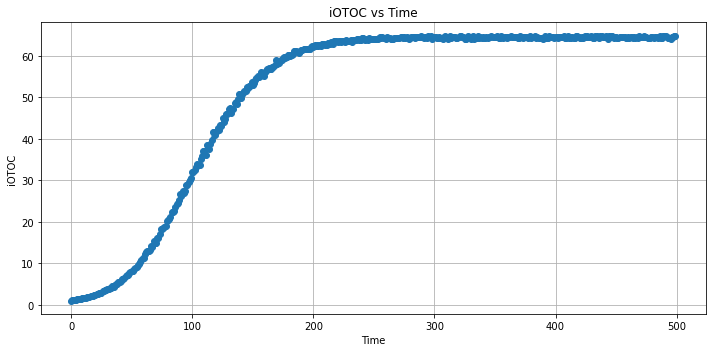

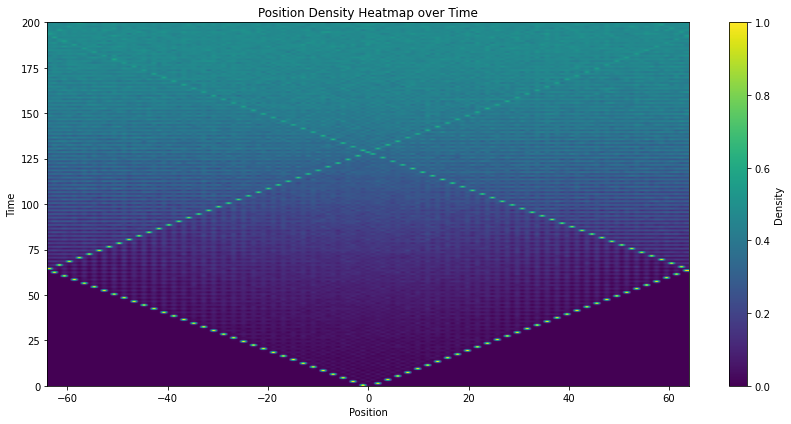

In [169]:
L = 129
T = 500
p = 1
r = 0.05
filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda
plot(filepath)

In [ ]:
L = 129
T = 500
p = 0.5
r = 0.05

iteration = 10

start_time = time.time()     
compute_iOTOC_counts_savedata(iteration, L, T, p, r, init_site=L//2)
end_time = time.time()
print(f"Execution time for compute all iOTOC_counts: {end_time - start_time:.4f} seconds")

Layers created


100%|██████████| 10/10 [00:00<00:00, 3218.22it/s]


Execution time for compute all iOTOC_counts: 208.8708 seconds


Butterfly velocity:  0.22266048912022463


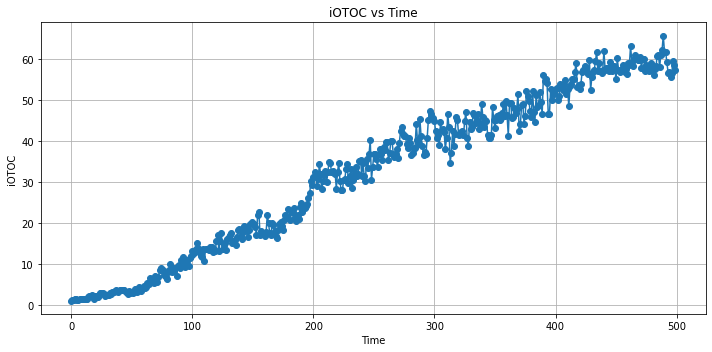

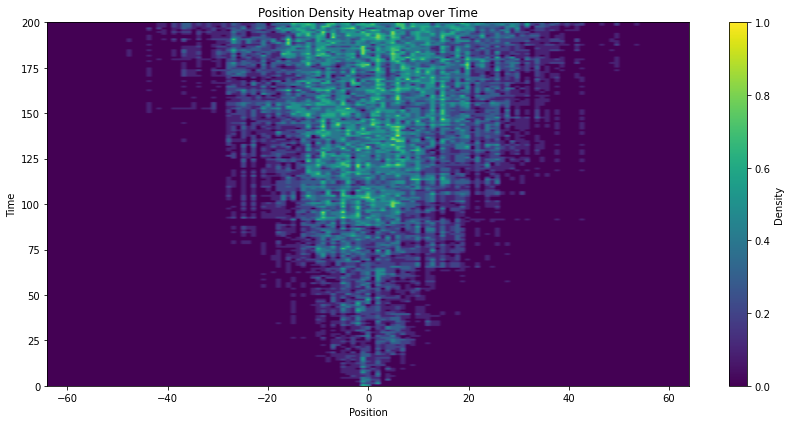

In [ ]:
L = 129
T = 500
p = 0.5
r = 0.05

filepath = f"numerical_data/iOTOC_n{L}_t{T}_p{p}_r{r}.dat"  # Ajusta según corresponda
plot(filepath)